In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from ipywidgets import interact, fixed, FloatSlider
%matplotlib inline

In [2]:
# load data and the pre-calculated table of CV values
# the sort_index calls are unnecessary but helps when visually comparing 2 tables side-by-side
cvs = pd.read_feather('../data/ESG_cv.feather').set_index('cetsid').sort_index(axis=1)
data = pd.read_feather('../data/ESG_wdi.feather')

# calculate an MRV table that has the same structure as the cvs table
mrv = data.pivot_table(index='indicatorID',columns='iso3c',values='date',aggfunc='max').sort_index(axis=1)

In [3]:
# here's what the layout looks like
mrv.head()

iso3c,ABW,AFG,AGO,ALB,AND,ARE,ARG,ARM,ASM,ATG,...,VGB,VIR,VNM,VUT,WSM,XKX,YEM,ZAF,ZMB,ZWE
indicatorID,,,,,,,,,,,,,,,,,,,,,
AG.LND.AGRI.ZS,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,...,2016.0,2016.0,2016.0,2016.0,2016.0,2007.0,2016.0,2016.0,2016.0,2016.0
AG.LND.FRST.ZS,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,...,2016.0,2016.0,2016.0,2016.0,2016.0,NaN,2016.0,2016.0,2016.0,2016.0
AG.LND.TOTL.K2,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,...,2018.0,2018.0,2018.0,2018.0,2018.0,2017.0,2018.0,2018.0,2018.0,2018.0
AG.PRD.FOOD.XD,NaN,2016.0,2016.0,2016.0,NaN,2016.0,2016.0,2016.0,2016.0,2016.0,...,2016.0,2016.0,2016.0,2016.0,2016.0,NaN,2016.0,2016.0,2016.0,2016.0
BN.CAB.XOKA.GD.ZS,2016.0,2018.0,2018.0,2018.0,NaN,NaN,2018.0,2018.0,NaN,2018.0,...,NaN,NaN,2018.0,2018.0,2018.0,2018.0,2016.0,2018.0,2018.0,2017.0


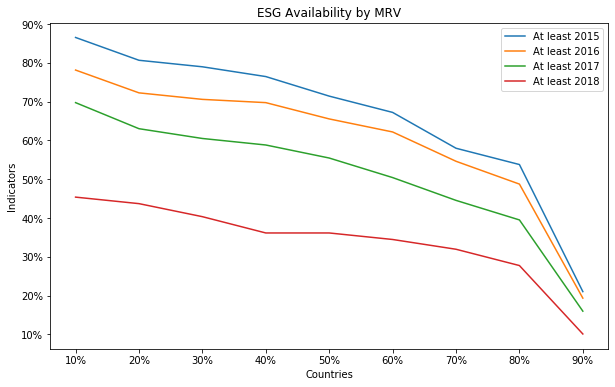

In [4]:
nIndicators = len(mrv.index)
nCountries  = len(mrv.columns)

# recreate the MRV availability chart from the first report
fig, ax = plt.subplots(figsize=(10,6))
plt.title('ESG Availability by MRV')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylabel('Indicators')
ax.set_xlabel('Countries')

x = np.arange(0.1,1,0.1)

for year in range(2015,2019):
    y = list()
    for t in x:
        y.append((mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries >= t).sum()/nIndicators)
    
    plt.plot(x, y, label='At least {}'.format(year))

plt.legend()
print()

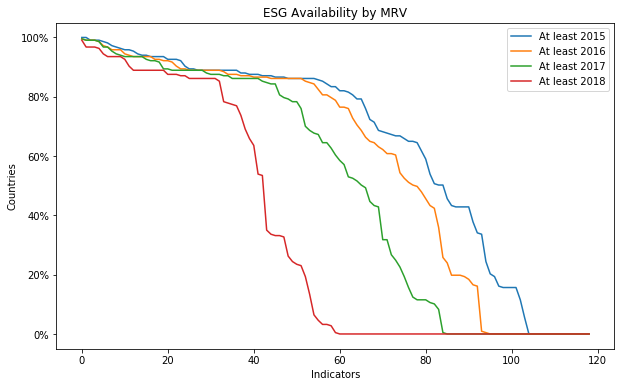

In [68]:
# Here's the same chart but with axes swapped and indicators in absolute counts to match the interactive tool below

# recreate the MRV availability chart from the first report
fig, ax = plt.subplots(figsize=(10,6))
plt.title('ESG Availability by MRV')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylabel('Countries')
ax.set_xlabel('Indicators')

x = range(nIndicators)

for year in range(2015,2019):
    y = (mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries).sort_values(ascending=False)    
    plt.plot(x, y, label='At least {}'.format(year))

plt.legend()
print()

We can calculate a coverage score *V* b/t 0 and 1 for a given year *y* as follows:

$$V_y = \frac{\sum_{i=1}^C \sum_{j=1}^S \left[M_{ij}>=y\right]}{CS}$$

* $S$ = number of indicators
* $C$ = number of countries
* $M$ = MRV for country $i$ and series $j$

This is the same as "area under the curve" in the charts above and below

In [5]:

year = 2018
mrv.apply(lambda x: x>=year).to_numpy().sum()/(nIndicators * nCountries)
# s = (mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries)
# s.where(s>=0.9).dropna()

0.3347016225845177

In [6]:
# Here we calculate the effect of imputing the MRV ahead by a number of
# years for any cv below a threshold
cv_min = 0.5
years_to_impute = 1

test_mrv = mrv + cvs.applymap(lambda x: years_to_impute if x<=cv_min else 0)
test_mrv.apply(lambda x: x>=year).to_numpy().sum()/(nIndicators * nCountries)

0.45928048638810365

In [59]:

def mrv_calc(year,cv_min,years_to_impute):
    
    if cv_min > 0:
        test_mrv = mrv + cvs.applymap(lambda x: years_to_impute if x<=cv_min else 0)
    else:
        test_mrv = mrv
        
    return test_mrv.apply(lambda x: x>=year).to_numpy().sum()/(nIndicators * nCountries)

def mrv_plot(year, cv_min, years_to_impute):
    
    fig, ax = plt.subplots(figsize=(10,6))
    plt.title('ESG Ranked Country Coverage for {:.0f}'.format(year))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.set_ylabel('Country Coverage')
    ax.set_xlabel('Indicators')
    x = range(len(mrv.index))
        
    if cv_min > 0:
        test_mrv = mrv + cvs.applymap(lambda x: years_to_impute if x<=cv_min else 0)
        y = (test_mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries).sort_values(ascending=False)
        plt.fill_between(x, y,alpha=0.25)
        plt.plot(x, y, label="With Imputation", color="blue")
        plt.annotate('AUC={:0.2f}'.format(y.sum()/nIndicators), xy=(0,0), xytext=(2,0.07), color="blue")

    # plot the unadjusted line as a reference
    y = (mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries).sort_values(ascending=False)
    plt.plot(x, y, color="red", label="Original values")
    plt.annotate('AUC={:0.2f}'.format(y.sum()/nIndicators), xy=(0,0), xytext=(2,0.02), color="red")
    plt.legend()
    

interact(mrv_plot,
         year=FloatSlider(min=2010,max=2019, value=2018, step=1, continuous_update=False,readout_format=".0f"),
         cv_min=FloatSlider(min=0.0,max=1.0, value=0.5, step=0.05, continuous_update=False),
         years_to_impute=FloatSlider(min=1,max=3, value=1, step=1, continuous_update=False,readout_format=".0f"))
print()

interactive(children=(FloatSlider(value=2018.0, continuous_update=False, description='year', max=2019.0, min=2…